<a href="https://colab.research.google.com/github/emirrtpl/adobe-dev-console/blob/main/bitirmeprojesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets==1.9.0 transformers tokenizers sentence-transformers umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.3/262.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 8.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 112.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install sentence-transformers

  Using cached sentence-transformers-2.2.2.tar.gz (85 kB)
  Preparing metadata (setup.py) ... done
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c1aec3f1af285a5ffa2bdbeefb655ab5093fd08c121fcb8b712f949c58d42b6b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.9 MB/s eta 0:00:00
  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Using cached multiprocess-0.70.15-py310-none-any.whl (134 kB)


In [4]:
!pip install umap-learn

  Using cached umap_learn-0.5.5-py3-none-any.whl
  Using cached pynndescent-0.5.11-py3-none-any.whl (55 kB)


In [5]:
pip install datashader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.8 MB/s eta 0:00:00


In [6]:

import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
import random
from sentence_transformers import SentenceTransformer, InputExample, evaluation, losses
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from datasets import list_datasets, load_dataset
import seaborn as sns
import umap
import umap.plot
import pprint
pd.options.display.max_colwidth = -1
pd.options.display.min_rows = 100

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
<ipython-input-6-73ef17fdcd94>:30: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


In [7]:
train_ex = 200000
test_ex = 20000

In [8]:
data = load_dataset("PolyAI/banking77")
data

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [9]:
pd.DataFrame({'t':data['train']['text'], 'l':data['train']['label']})\
.groupby('l')\
.apply(lambda x: list(x['t'][:5])).reset_index()

,l,0
0,0,"[Please help me with my card. It won't activate., I tired but an unable to activate my card., I want to start using my card., How do I verify my new card?, I tried activating my plug-in and it didn't piece of work]"
1,1,"[I want to open an account for my children, How old do you need to be to use the banks services?, Whats the minimum age to have an account, Can my children open an account?, How old do I need to be?]"
2,2,"[Hi, I have an apple watch. How do I use it to top up my card?, Can I use google pay to top up?, why top up is not working even if I got my American Express in Apple Bay?, Can I deposit money using Apple Pay?, Can I use google pay for topping -up]"
3,3,"[I can use this card at which ATMs?, Can I use the card at any cash machine?, What locations can I get money from?, What ATMs take this card?, Which ATM's can I use to make a withdrawal?]"
4,4,"[Can I add money automatically to my account while traveling?, i need help finding the auto top up option., What are the maximum amount you can do for auto top-up?, I can't find the auto-top up option., Does the auto top-up have any limits?]"
5,5,"[help my money isnt showing up, how do i see what i transferred, Hello. Can you help figure out why the recent transfer from my UK bank account isn't showing up?, I've made a transfer from France two days ago but I was wondering if international transfers take longer to arrive because it hasn't made it yet., After I transferred money the balance remained the same.]"
6,6,"[Why is my last cheque deposit taking so long?, I am still waiting for a the cash I deposited this morning, I tried using a check to update my balance, but it isn't work? Is something wrong?, I deposited cash but it isn't showing up in my account, I put some cash into my account but it's not displaying that on my balance.]"
7,7,"[is there something blocking me from making transfers, What are the reasons for my beneficiary not being allowed?, Is there something wrong with the transferring functions? I keep trying to transfer funds and only get an error message., What are the reasons a beneficiary would be denied?, A transfer to my account was denied.]"
8,8,"[Cancel a transaction, Am I able to cancel a transfer I just made, I needed to make a payment on my account, but I typed in the incorrect number. The app won't allow me to cancel this transaction. I need it cancelled ASAP!!, I made a mistake this morning when I did a transfer. How do I reverse it?, Can I cancel a transaction?]"
9,9,"[Are there any express fees if i want my new card faster?, Do I need to do something to get a new card once it expires?, I am overseas in China, can I get a replacement card?, Can I get a new card with new expiration date in China?, Are there restrictions on new cards in China?]"


In [10]:
def create_pair_data(text, labels, size):
    data_dict = {}
    for x in  pd.DataFrame({"text":text,
                          "label":labels})\
            .groupby("label")\
            .apply(lambda x: list(x["text"]))\
            .reset_index().values.tolist() :
        data_dict[x[0]] = x[1]
    label1 = []
    for d in data_dict.keys():
        label1.extend(list(itertools.combinations(data_dict[d], 2)))
    #print(len(label1))

    label0 = []
    for d1 in data_dict.keys():
        for d2 in data_dict.keys():
            if d1 != d2:
                label0.extend(list(itertools.product(data_dict[d1], data_dict[d2])))
    #print(len(label0))
    label0 = random.sample(label0, len(label1))
    #print(len(label0))
    return random.sample(label1, int(size/2)), random.sample(label0, int(size/2))

In [11]:
train_label_1, train_label_0 = create_pair_data(data["train"]['text'],
                                                data["train"]['label'], train_ex)

In [12]:
test_label_1, test_label_0 = create_pair_data(data["test"]['text'],
                                              data["test"]['label'],
                                              test_ex)
print(len(test_label_1), len(test_label_0))
pprint.pprint(test_label_0[:2])
pprint.pprint(test_label_1[:2])

10000 10000
[('Is it possible to top up with cash? If so how do I do it?',
  'Where on the website do I go to link my card?'),
 ('Where can cards be delivered?',
  'When can I expect my card to be delivered to the US?')]
[('Why is my card not working?',
  'Could it be that I deactivated my card, its not working?'),
 ("What do I do if my virtual card won't work.",
  "Why can't I get my virtual card to work?")]


In [13]:
train_examples = [InputExample(texts=x, label=1.0) for x in train_label_1] + \
                 [InputExample(texts=x, label=0.0) for x in train_label_0]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)

In [14]:
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)
#sonradan t5 ile degistirilebilir

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

0.5962616
0.21270835


<ipython-input-15-ea2265baad2e>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cosine_scores[:int(test_ex/2)], label = "1")
<ipython-input-15-ea2265baad2e>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cosine_scores[int(test_ex/2):], label = "0")


<Axes: ylabel='Density'>

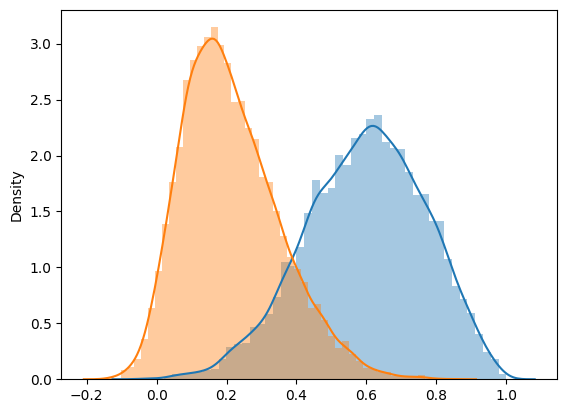

In [15]:
embeddings1 = model.encode([x[0] for x in test_label_1] + [x[0] for x in test_label_0],
                           batch_size= 8, show_progress_bar=True, convert_to_numpy=True)

embeddings2 = model.encode([x[1] for x in test_label_1] + [x[1] for x in test_label_0],
                           batch_size= 8, show_progress_bar=True, convert_to_numpy=True)

labels = [1]*len(test_label_1) + [0]*len(test_label_0)

cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))

print(cosine_scores[:int(test_ex/2)].mean())
print(cosine_scores[int(test_ex/2):].mean())


sns.distplot(cosine_scores[:int(test_ex/2)], label = "1")
sns.distplot(cosine_scores[int(test_ex/2):], label = "0")

In [16]:
# Show the bad predictions

tmp_df = pd.DataFrame({"s1":[x[0] for x in test_label_1] + [x[0] for x in test_label_0],
              "s2":[x[1] for x in test_label_1] + [x[1] for x in test_label_0],
              "lbl":[1]*len(test_label_1) + [0]*len(test_label_0),
              "cos": cosine_scores})\
.assign(delta = lambda x: np.abs(x.lbl - x.cos)).sort_values("delta", ascending=False)

# getting correct incorrect match
scores = []
for x in range(10,90,1):
    scores.append( ( x/100, tmp_df.assign(pred = lambda xx: xx.cos > x/100 )\
          .assign(correct = lambda xxx: xxx.pred == xxx.lbl).correct.mean() ) )

best_score = sorted(scores, key = lambda x: x[1], reverse = True)[0]
print("Best accuracy of {} using threshold {}".format(best_score[1], best_score[0]))

print("\nBad predictions - ")
tmp_df.head(50)

Best accuracy of 0.8838 using threshold 0.39

Bad predictions - 


,s1,s2,lbl,cos,delta
3649,Can I space out how often money is transferred along my travels?,Can you explain where I can find the auto-top option?,1,-0.044728,1.044728
4982,What's the deal with no cryptocurrency on your app?,What are the rules for transferring to a beneficiary?,1,-0.029351,1.029351
2366,Can I space out how often money is transferred along my travels?,What is the highest limit for Auto Top?,1,-0.013831,1.013831
689,Can I get a card outside the UK?,Where do you support?,1,-0.012248,1.012248
8699,Where do you support?,Can the card be mailed and used in Europe?,1,0.018362,0.981638
373,what is required documents for new card process ?,Why isn't my contactless not working?,1,0.033262,0.966738
6999,How do I do a successful transfer to an account?,What's the deal with no cryptocurrency on your app?,1,0.033592,0.966408
9701,I was mugged and everything taken. What do I do to protect my account?,Can I still use the app if I switched phones?,1,0.037530,0.962470
2429,"There is an incoming payment into my account, but it is deactivated. Will they still be processed?",Which country's currency do you support?,1,0.037655,0.962345
1646,"There is an incoming payment into my account, but it is deactivated. Will they still be processed?","In terms of holding and exchange, what fiat currencies do you use.",1,0.050708,0.949292


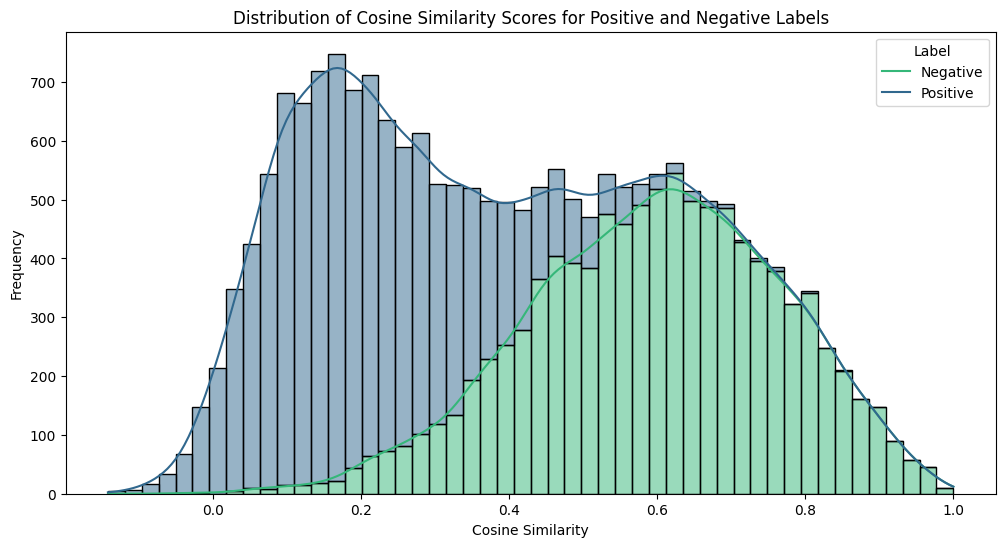

In [17]:
# Pozitif ve Negatif Etiketli Çiftlerin Benzerlik Skorları Histogramı
plt.figure(figsize=(12, 6))
sns.histplot(tmp_df, x='cos', hue='lbl', bins=50, kde=True, multiple='stack', palette='viridis')
plt.title('Distribution of Cosine Similarity Scores for Positive and Negative Labels')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Negative', 'Positive'])
plt.show()

Batches:   0%|          | 0/385 [00:00<?, ?it/s]

<Axes: >

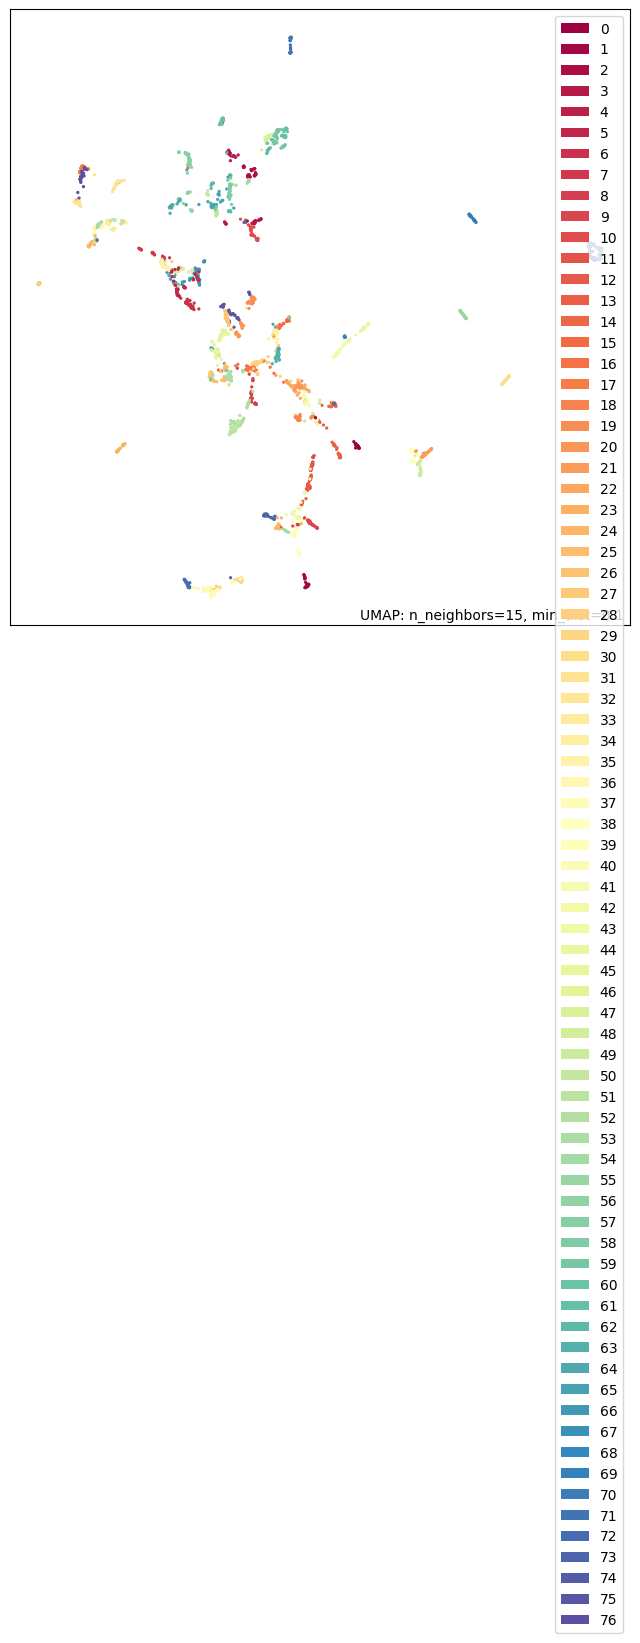

In [18]:
embeddings3 = model.encode(data["test"]["text"], batch_size= 8,
                           show_progress_bar=True, convert_to_numpy=True)

embedding_umap = umap.UMAP(n_components=2,).fit(embeddings3)

umap.plot.points(embedding_umap, labels=pd.Series(data["test"]["label"]))

In [19]:
pip install Flask sentence-transformers

In [27]:
from sentence_transformers import SentenceTransformer, util

In [24]:
user_input = "I want a debit card. Can you help me?"
user_embedding = model.encode(user_input, convert_to_tensor=True)
predefined_responses = ["Please help me with my card. It won't activate.", "I tired but an unable to activate my card."," I want to start using my card."]
similarities = util.pytorch_cos_sim(user_embedding, model.encode(predefined_responses, convert_to_tensor=True))
most_similar_index = similarities.argmax().item()
response = predefined_responses[most_similar_index]

In [25]:
print("Kullanıcının Girdisi:", user_input)
print("En Benzer Yanıt:", response)

Kullanıcının Girdisi: I want a debit card. Can you help me?
En Benzer Yanıt:  I want to start using my card.


In [28]:
pip install sentence-transformers